# Антиспам

In [36]:
from __future__ import division

import base64
import csv
import gzip
import zlib

from random import randrange
import os
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor as LOF
from multiprocessing import Process, Queue, Lock, Pool
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import namedtuple
from sklearn.decomposition import NMF
from bs4 import BeautifulSoup
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import itertools 
import numpy as np
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.utils.estimator_checks import check_estimator
from sklearn.base import BaseEstimator, ClassifierMixin
from tqdm.notebook import tqdm
from sklearn.utils.multiclass import unique_labels

%matplotlib inline
import matplotlib.pyplot as plt

In [37]:
TRACE_NUM = 1000
import logging
import importlib
importlib.reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

def trace(items_num, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d" % items_num)
        
def trace_worker(items_num, worker_id, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d in worker_id %d" % (items_num, worker_id))

### Извлечение текста из html

In [38]:
from html.parser import HTMLParser
import re

###Извлечение текста из title можно вписать сюда

class TextHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self._text = []
        self._title = ""
        self._in_title = False

    def handle_data(self, data):
        text = data.strip()
        if len(text) > 0:
            text = re.sub('[ \t\r\n]+', ' ', text)
            self._text.append(text + ' ')

    def handle_starttag(self, tag, attrs):
        if tag == 'p':
            self._text.append('\n\n')
        elif tag == 'br':
            self._text.append('\n')
        elif tag == 'title':
            self._in_title = True

    def handle_startendtag(self, tag, attrs):
        if tag == 'br':
            self._text.append('\n\n')

    def text(self):
        return ''.join(self._text).strip()

def html2text_parser(text):
    parser = TextHTMLParser()
    parser.feed(text)
    return parser.text()

#### Извлечение текста при помощи дополнительных библиотек

In [39]:
def html2text_bs(raw_html):
    """
    Тут производится извлечения из html текста
    """
    soup = BeautifulSoup(raw_html, "html.parser")
    return ' '.join( [s.extract().get_text() for s in soup(['script', 'style'])] )

def html2text_bs_visible(raw_html):
    """
    Тут производится извлечения из html текста, который видим пользователю
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    return ' '.join( [s.extract().get_text() for s in 
                          soup(['style', 'script', '[document]', 'head', 'title'])] )


def html2text_bs_title(raw_html):
    """
    Тут производится извлечения из html - title
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    return ' '.join( [s.extract().get_text() for s in soup(['title'])] )


def html2text_bs_anchors(raw_html):
    """
    Тут производится извлечения из html - title
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    return ' '.join( [s.extract().get_text() for s in soup(['a'])] )


def html2text_bs_keywords(raw_html):
    soup = BeautifulSoup(raw_html, "html.parser")   
    kw = soup.find("meta", attrs={"name": "keywords"})
    return kw.get('content', "") if kw else ""


def html2text_bs_select(raw_html):
    """
    Тут производится извлечения из html - b i 
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    return ' '.join( [s.extract().get_text() for s in soup(['b', 'i'])] )


def html2text_bs_scripts_count(raw_html):
    """
    Тут производится извлечения из html - title
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    return len( [s.extract() for s in soup(['script'])] )

def html2text_bs_tags_count(raw_html):
    """
    Тут производится извлечения из html - title
    """
    soup = BeautifulSoup(raw_html, "html.parser") 
    return len([tag.name for tag in soup.findAll()])

#### Выбираем какой метод для конвертации html в текст будет основным

In [40]:
#html2text = html2text_bs
html2text = html2text_parser

#### Методы для токенизации текста

In [41]:
def easy_tokenizer(text):
    
    word = str()
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = str()
    if word: yield word


def my_tokenizer(text):
    return re.findall(r'\w+', text)        
        

PYMORPHY_CACHE = {}
MORPH = None
#hint, чтобы установка pymorphy2 не была бы обязательной

def get_lemmatizer():
    import pymorphy2
    global MORPH
    if MORPH is None: MORPH = pymorphy2.MorphAnalyzer()
    return MORPH

def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE
    for word in easy_tokenizer(text):
        word_hash = hash(word)
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = get_lemmatizer().parse(word)[0].normal_form            
        yield PYMORPHY_CACHE[word_hash]

#### Основная функция, которая вызывается для преобразования html в список слов

In [42]:
def html2word(raw_html, to_text=html2text, tokenizer=pymorphy_tokenizer): # my_tokenizer 
    return tokenizer(to_text(raw_html).lower())

#### Рассчет финальных метрик

In [43]:
def safe_divide(a, b):
    if a == 0: return 0.0
    elif b == 0: return 0.0
    else: return a/b

def calculate_metrics(predictions, threshold):    
    """
    Функция подсчета метрик
    Параметры
    predictions - ранки по документам
    threshold  - порог для метрик
    """
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for (url_id, mark, url, prediction) in predictions:        
        mark_predict = prediction > threshold

        if mark_predict:                     
            if mark_predict == mark: true_positive += 1
            else: false_positive += 1                    
        else:                     
            if  mark_predict == mark: true_negative += 1
            else: false_negative += 1

    class_prec  = safe_divide(true_positive, true_positive + false_positive)
    class_recall = safe_divide(true_positive, true_positive + false_negative)
        
    class_F1 = safe_divide(2 * class_prec * class_recall, class_prec + class_recall)
    
    
    not_class_prec = safe_divide(true_negative, true_negative + false_negative)
    not_class_recall = safe_divide(true_negative, true_negative + false_positive)
    
    not_class_F1 = safe_divide(2 * not_class_prec * not_class_recall, not_class_prec + not_class_recall)
    
    return ( (class_prec, class_recall, class_F1), (not_class_prec, not_class_recall, not_class_F1) )

def arange(start, stop, step):
    cur_value = start
    while True:
        if cur_value > stop: break
        yield cur_value
        cur_value += step

def plot_results(docs, min_threshold=-1, max_threshold=1, step=0.1, trace=False):
    x = []
    y_p = []
    y_n = []
    docs_predictions = classifier.predict_all(docs)
    for threshold in arange(min_threshold, max_threshold, step):
        r = calculate_metrics(docs_predictions, threshold)
        x.append(threshold)
        y_p.append(r[0])
        y_n.append(r[1])        
        if trace: 
            print('threshold %s' % threshold)
            print('\tclass_prec %s, class_recall %s, class_F1 %s' % r[0])
            print('\tnot_class_prec %s, not_class_recall %s, not_class_F1 %s' % r[1])
            print('\t\tMacroF1Mesure %s' % ((r[0][2] + r[1][2])/2))
    plot_stats(x, y_p, "Class Result")
    plot_stats(x, y_n, "Not class Result")    


def plot_stats(x, y, title):
    plt.figure(figsize=(10, 5))

    prec, = plt.plot( x, 
                     [k[0] for k in y], "r", label='Precision', 
                     linewidth=1)
    accur, = plt.plot( x, 
                      [k[1] for k in y], "b", label='Recall',
                      linewidth=1)
    f1, =    plt.plot( x, 
                      [k[2] for k in y], "g", label='F1',
                      linewidth=1)
    plt.grid(True)
    plt.legend(handles=[prec, accur, f1])
    plt.title(title)
    plt.show()

## TODO:

- написать SVM-классификатор
- написать Random Forest
- написать Boosting 
- написать наивного байесовского классификатора
- написать голосование/стекинг/блендинг

#### Гиперпараметры

In [44]:
N_COMPONENTS = 20
MAX_ITER = 500
NU = 0.71
CONTAMINATION = 0.5
N_NEIGHBORS = 50
TRAIN_DATA_FILE  = 'kaggle_train_data_tab.csv'
TEST_DATA_FILE  = 'kaggle_test_data_tab.csv'

#### Функции для признаков

In [45]:
def get_avg_word_len(words):
    lens = list(map(len, words))
    return sum(lens) / len(lens) if len(lens) > 0 else 0


def get_compression_level(html_data):
    num = str(randrange(1009))
    filename = ''.join(('./tmp', num, '.gz'))
    with gzip.open(filename, 'wb') as f:
        f.write(html_data.encode())
    # os.stat(filename).st_size # TODO: не совсем честно, лучше прочитать и посчитать 
    with open(filename, 'rb') as f:
        return len(html_data) / len(f.read())
    
    os.remove(filename)
    
    print('get_compression_level: some problems')    


def get_vectorizer(docs):
    v = TfidfVectorizer()
    v.fit(docs)
    return v
    
    
def get_idf_dict(docs, vectorizer):
    idf = vectorizer.idf_
    return dict(zip(vectorizer.get_feature_names(), idf))
    

def get_sum_idf(docs, idf_dict, html2text_bs_func):
    features = []
    for html_data in docs:
        res = 0
        words = list( html2word(html_data, to_text=html2text_bs_func) ) # 
        for word in words:
            res += idf_dict.get(word, 0) # если слова нет в словаре, вернем 0
        features.append(res)
    return features


def get_script_ratio(html_data): # useless
    return html2text_bs_scripts_count(html_data) / html2text_bs_tags_count(html_data)
    #return html2text_bs_scripts_count(html_data)


def svm_feature(vectors, nu=NU):
    svm = OneClassSVM(nu=nu)
    svm.fit(vectors)
    return svm.decision_function(vectors)


def lof_feature(vectors, contamination=CONTAMINATION, n_neighbors=N_NEIGHBORS): # плохо
    lof = LOF(contamination=contamination, n_neighbors=n_neighbors)
    return lof.decision_function(vectors)


def get_entropy(vectors): # tfidf. очень много жрёт
    from scipy.stats import entropy
    return entropy(vectors.T)

#### Извлечение признаков

In [46]:
def calc_features(docs):
    
    res = []
#    for html_data in tqdm(docs):
#         words = list( html2word(html_data) )
#         title_words = list( html2word(html_data, to_text=html2text_bs_title) )
#         anchors_words = list( html2word(html_data, to_text=html2text_bs_anchors) )

#         words_num = len(words)
#         avg_word_len = get_avg_word_len(words)
#         title_words_num = len(title_words)
#         anchor_words_num = len(anchors_words)
#         compression_level = get_compression_level( ' '.join( list( html2word(html_data))) )
#         scripts_ratio = get_script_ratio(html_data)

        #res.append()

#         res.append( [len(words), avg_word_len, title_words_num, anchor_words_num,
#                      compression_level, scripts_ratio] )
        
    print('get vectorizer...')
    vectorizer = get_vectorizer(docs)
    
    print('get idfs...')
    idf_dict = get_idf_dict(docs, vectorizer)
    
    print('create nmf...')
    nmf = NMF(n_components=N_COMPONENTS, max_iter=MAX_ITER, init='random', random_state=0)
    
    print('start tf-idf vectorize...')
    vectors = vectorizer.transform(docs)
    
    print('start nmf reduce...')
    vectors = nmf.fit_transform(vectors)
    
    return get_entropy(vectors)
    
#     print('get sum idfs...')
#     new_features = [ get_sum_idf(docs, idf_dict, html2text_bs_keywords),
#                         get_sum_idf(docs, idf_dict, html2text_bs_select),
#                         get_sum_idf(docs, idf_dict, html2text_bs_title),
#                         svm_feature(vectors) ]
    
#     print('start concatenate...')
    
#     for i, lst in enumerate(zip(*new_features)):
#         res[i] += lst
    
#    return res

In [49]:
DocItem = namedtuple('DocItem', ['doc_id', 'is_spam', 'url', 'features'])

WORKER_NUM = 4

def load_csv(input_file_name, calc_features_f):    
    """
    Загружаем данные и извлекаем на лету признаки
    Сам контент не сохраняется, чтобы уменьшить потребление памяти - чтобы
    можно было запускать даже на ноутбуках в классе
    """
    global LAST_HTML
    with gzip.open(input_file_name, mode='rt', encoding='utf8') if input_file_name.endswith('gz') else open(input_file_name, mode='rt', encoding='utf8')  as input_file:            
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            trace(i)
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            try:
                html_data = html_data.decode('utf8')
            except:
                html_data = html_data.decode('latin1')
            features = calc_features_f(url, html_data)            
            yield DocItem(url_id, mark, url, features)            
                
        trace(i, 1)  
        
def load_csv_worker(input_file_name, calc_features_f, worker_id, res_queue):    
    with gzip.open(input_file_name,  mode='rt', encoding='utf8') if input_file_name.endswith('gz') else open(input_file_name, mode='rt', encoding='utf8') as input_file:            
        headers = input_file.readline()

        for i, line in tqdm(enumerate(input_file)):
            trace_worker(i, worker_id)
            if i % WORKER_NUM != worker_id: continue
            
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            try:
                html_data = html_data.decode('utf8')
            except:
                html_data = html_data.decode('latin1')
            features = calc_features_f(url, html_data)
            res_queue.put(DocItem(url_id, mark, url, features))
                
        trace_worker(i, worker_id, 1)  
    res_queue.put(None)


def old_load_csv_multiprocess(input_file_name, calc_features_f):
    processes = []
    res_queue = Queue()
    
    for i in range(WORKER_NUM):
        process = Process(target=load_csv_worker, args=(input_file_name, calc_features_f, i, res_queue))
        processes.append(process)
        process.start()
    
    complete_workers = 0
    while complete_workers != WORKER_NUM:
        item = res_queue.get()
        if item is None:
            complete_workers += 1
        else:
            yield item
        
    for process in processes: process.join()
        
#pool.join()
        
        
def load_csv_multiprocess(input_file_name, calc_features_f):
    
    queue = Queue()
    
    with open(input_file_name, mode='rt', encoding='utf8') as input_file:
        cnt = -1
        for line in input_file:
            cnt += 1

    for i in range(cnt):
        queue.put(i)
    
    with Pool(processes=4) as pool, tqdm(total=queue.qsize()) as pbar:
        lock = pbar.get_lock()
        pool.map(process_page_wrapper, range(pool._processes))
        
        
def get_docs(input_file_name):
    docs = []
    marks = []
    with open(input_file_name, mode='rt', encoding='utf8') as input_file:            
        headers = input_file.readline()

        for i, line in tqdm(enumerate(input_file)):
            
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            try:
                html_data = html_data.decode('utf8')
            except:
                html_data = html_data.decode('latin1')
            
            docs.append( html_data )
            marks.append( mark )
                
    return docs, marks


def get_urls(input_file_name):
    docs = []
    marks = []
    with open(input_file_name, mode='rt', encoding='utf8') as input_file:            
        headers = input_file.readline()

        for i, line in tqdm(enumerate(input_file)):
            
            parts = line.strip().split('\t')
            mark = bool(int(parts[1]))
            url = parts[2]

            docs.append( url )
            marks.append( mark )
                
    return docs, marks

In [50]:
urls, marks = get_urls(TRAIN_DATA_FILE)

In [ ]:
marks = np.array(marks)

In [54]:
from urllib.parse import urlparse

In [108]:
i = 0
for url, mark in zip(urls, marks):
    if i > 100:
        if mark:
            print(urlparse(url))
            print()
    i += 1
    if i > 140:
        break

ParseResult(scheme='http', netloc='alice1042.newmail.ru', path='/1319251270.html', params='', query='', fragment='')

ParseResult(scheme='http', netloc='buklet66.ru', path='/arenda-kvartiry-bez-posrednikov-na-televizionnom-zavode-v-omske.html', params='', query='', fragment='')

ParseResult(scheme='http', netloc='agilepc.com', path='/archives/2397', params='', query='', fragment='')

ParseResult(scheme='http', netloc='missfitw.dousetsu.com', path='/ludchshaya-dieta-dlya-devushki-v-16-let.html', params='', query='', fragment='')

ParseResult(scheme='http', netloc='cfbeaafa.tk', path='/samouchitel-razrabotchika-ustroystv-na-mikrokontrollerah-avr.html', params='', query='', fragment='')

ParseResult(scheme='http', netloc='urxoaxutlu.undonet.com', path='/proi-buma-pake.html', params='', query='', fragment='')

ParseResult(scheme='http', netloc='chalute.110mb.com', path='/64vip-prostitutki-v-v-novgorode.htm', params='', query='', fragment='')

ParseResult(scheme='http', netloc='spirarcor.na

In [61]:
i = 0
for url, mark in zip(urls, marks):
    if not mark:
        print(urlparse(url), mark)
        print()
    i += 1
    if i > 10:
        break

ParseResult(scheme='http', netloc='lawleader.ru', path='/docs/32/', params='', query='', fragment='') False

ParseResult(scheme='http', netloc='alterhost.ruwww.alterhost.ruwww.user.kz.ru', path='/', params='', query='', fragment='') False

ParseResult(scheme='http', netloc='www.ferio.ru', path='/c_1-acura-legend.html', params='', query='', fragment='') False

ParseResult(scheme='http', netloc='fshops.otzyv.ru', path='/read.php', params='', query='id=277', fragment='') False

ParseResult(scheme='http', netloc='www.ocgsen.nnov.ru', path='/', params='', query='', fragment='') False



In [77]:
spam_dom = dict()
norm_dom = dict()
for url, mark in zip(urls, marks):
    dom = urlparse(url).netloc.split('.')[-1]
    if mark:
        spam_dom[dom] = spam_dom.get(dom, 0) + 1
    else:
        norm_dom[dom] = norm_dom.get(dom, 0) + 1

In [78]:
len(spam_dom), len(norm_dom)

(48, 32)

In [91]:
sorted([(spam_dom[key], key) for key in spam_dom], reverse=True)

[(1626, 'ru'),
 (631, 'com'),
 (503, 'cc'),
 (313, 'ms'),
 (207, 'cz'),
 (138, 'net'),
 (123, 'info'),
 (110, 'tk'),
 (58, 'ua'),
 (51, 'org'),
 (48, 'biz'),
 (47, 'nu'),
 (47, 'ir'),
 (40, 'pl'),
 (30, 'su'),
 (20, 'me'),
 (13, 'tv'),
 (12, 'de'),
 (11, 'sk'),
 (11, 'nf'),
 (9, 'eu'),
 (8, 'xn--p1ai'),
 (8, 'lv'),
 (6, 'us'),
 (5, 'lc'),
 (5, 'gp'),
 (3, 'in'),
 (3, 'es'),
 (2, 'jp'),
 (2, 'im'),
 (2, 'be'),
 (1, 'ws'),
 (1, 'vg'),
 (1, 'uz'),
 (1, 'st'),
 (1, 'ro'),
 (1, 'nl'),
 (1, 'mu'),
 (1, 'lt'),
 (1, 'gs'),
 (1, 'gl'),
 (1, 'gd'),
 (1, 'fr'),
 (1, 'ec'),
 (1, 'dj'),
 (1, 'by'),
 (1, 'au'),
 (1, 'at')]

In [105]:
not_accept = sorted([(spam_dom[key], key) for key in spam_dom], reverse=True)
not_acceptable_dict = dict()
for count, domain in not_accept:
    not_acceptable_dict[domain] = count / not_accept[0][0]

In [106]:
not_acceptable_dict

{'ru': 1.0,
 'com': 0.3880688806888069,
 'cc': 0.3093480934809348,
 'ms': 0.1924969249692497,
 'cz': 0.12730627306273062,
 'net': 0.08487084870848709,
 'info': 0.07564575645756458,
 'tk': 0.06765067650676507,
 'ua': 0.03567035670356704,
 'org': 0.03136531365313653,
 'biz': 0.02952029520295203,
 'nu': 0.02890528905289053,
 'ir': 0.02890528905289053,
 'pl': 0.024600246002460024,
 'su': 0.01845018450184502,
 'me': 0.012300123001230012,
 'tv': 0.007995079950799507,
 'de': 0.007380073800738007,
 'sk': 0.006765067650676507,
 'nf': 0.006765067650676507,
 'eu': 0.005535055350553505,
 'xn--p1ai': 0.004920049200492005,
 'lv': 0.004920049200492005,
 'us': 0.0036900369003690036,
 'lc': 0.003075030750307503,
 'gp': 0.003075030750307503,
 'in': 0.0018450184501845018,
 'es': 0.0018450184501845018,
 'jp': 0.0012300123001230013,
 'im': 0.0012300123001230013,
 'be': 0.0012300123001230013,
 'ws': 0.0006150061500615006,
 'vg': 0.0006150061500615006,
 'uz': 0.0006150061500615006,
 'st': 0.00061500615006150

In [ ]:
norm_dim

In [98]:
accept = sorted([(norm_dom[key], key) for key in norm_dom], reverse=True)[:9]
accept

[(2206, 'ru'),
 (247, 'com'),
 (139, 'ua'),
 (92, 'net'),
 (52, 'kz'),
 (48, 'info'),
 (46, 'org'),
 (29, 'su'),
 (27, 'by')]

In [101]:
acceptable_dict = dict()
for count, domain in accept:
    acceptable_dict[domain] = count / accept[0][0]

In [102]:
acceptable_dict

{'ru': 1.0,
 'com': 0.11196736174070716,
 'ua': 0.06300997280145058,
 'net': 0.04170444242973708,
 'kz': 0.02357207615593835,
 'info': 0.021758839528558477,
 'org': 0.02085222121486854,
 'su': 0.01314596554850408,
 'by': 0.012239347234814143}

In [13]:
# docc, marks = get_docs(TRAIN_DATA_FILE)

#### Тестируем

In [15]:
def get_features(data_file, calc_features_f):
    train_docs, target = get_docs(data_file)
    features = calc_features_f(train_docs)
    
    return features, target

In [17]:
# X_train, y_train = get_features(TRAIN_DATA_FILE, calc_features)
# np.save("x_train_ent.npy", X_train)
# np.save("y_train_ent.npy", y_train)


# X_test, y_test = get_features(TEST_DATA_FILE, calc_features)
# np.save("x_test_ent.npy", X_test)
# np.save("y_test_ent.npy", y_test)

# x10 = np.load("x_test.npy")
# x_ent = np.load("x_test_ent.npy")
# y10 = np.load("y_test.npy")
# x11 = np.concatenate( (x10, x_ent[:, None]), axis=1 )
# np.save("x11_test.npy", x11)
# np.save("y11_test.npy", y10)

** Обрабатываем входной файл **
<br>
Формат - поля разделенные табуляциями
<br>
0 - идентификатор документа
<br>
1 - метка класса 0 - не спам, 1 - спам
<br>
2 - урл документа
<br>
3 - документ в кодировке base64

Выходной формат - массив кортежей вида
(doc_id, is_spam, url, html_data)

## Графики

In [21]:
def plot_features(feat_num, feat_name, bins, X, y):
    is_spam_data = [feat[feat_num] for feat, label in zip(X, y) if label == True]
    not_spam_data = [feat[feat_num] for feat, label in zip(X, y) if label == False]
    plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
    plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
    plt.title(feat_name)
    plt.legend()
    plt.show()

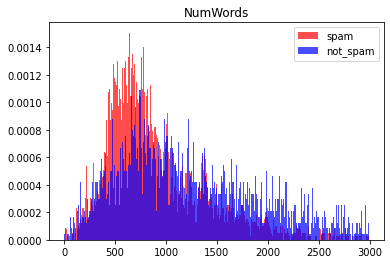

In [37]:
plot_features(0, 'NumWords', bins = range(0,3000,10))

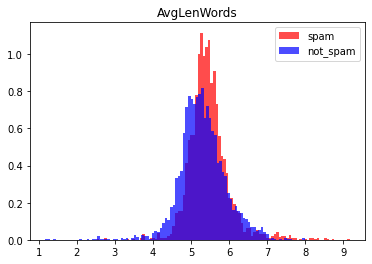

In [38]:
plot_features(1, 'AvgLenWords', bins = 100)

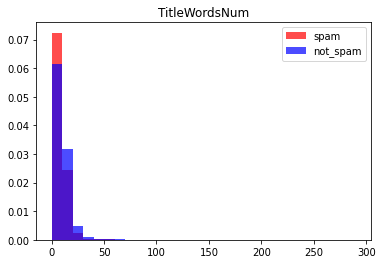

In [39]:
plot_features(2, 'TitleWordsNum', bins = range(0,300,10))

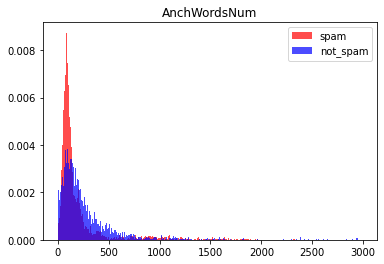

In [40]:
plot_features(3, 'AnchWordsNum', bins = range(0,3000,10))

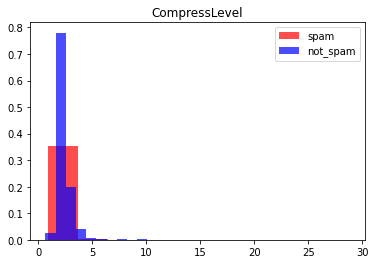

In [47]:
plot_features(4, 'CompressLevel', bins = 10)

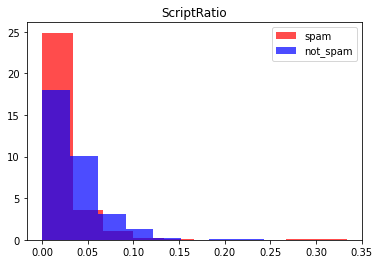

In [49]:
plot_features(5, 'ScriptRatio', bins = 10)

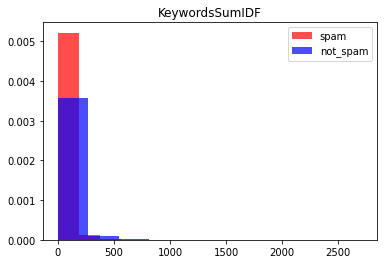

In [21]:
plot_features(6, 'KeywordsSumIDF', 10, X_train, y_train)

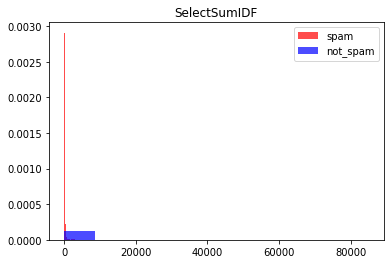

In [20]:
plot_features(7, 'SelectSumIDF', bins = 10)

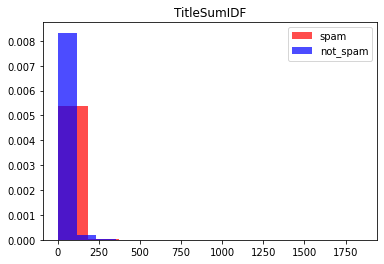

In [21]:
plot_features(8, 'TitleSumIDF', bins = 10)

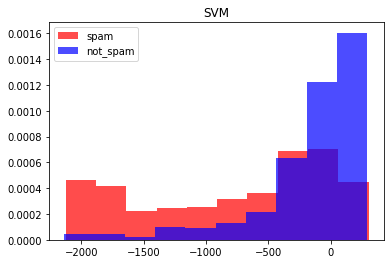

In [22]:
plot_features(9, 'SVM', bins = 10)

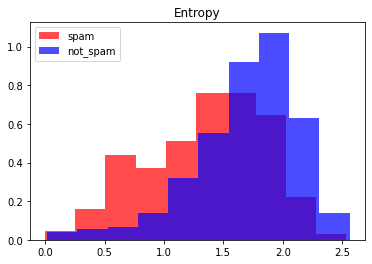

In [25]:
plot_features(10, 'Entropy', bins = 10, X=X_train[:, None], y=y_train)

** Классификатор: **
Нужно реализовать

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [ ]:
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB

In [ ]:
estimators = [
    ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
    ('svr', make_pipeline(StandardScaler(),
            LinearSVC(random_state=42)))
    ]
model = StackingClassifier(
        estimators=estimators, final_estimator=LogisticRegression() )

In [19]:
class Classifier:
    
    def __init__(self):
        
        self.model = SVC(c=1.0)
        """
        self.model = xgb.XGBClassifier()
        """
        """
        self.model = GaussianNB()
        """
        
    def predict(self, X_test):
        """
        D_test = xgb.DMatrix(X_test, label=Y_test)
        preds = self.model.predict(D_test)
        best_preds = np.asarray([np.argmax(line) for line in preds])
        return best_preds
        """
        """
        return self.model.predict(X_test)
        """
        return self.model.predict(X_test)
    
    def train(self, X_train, y_train):         
        """
        D_train = xgb.DMatrix(X_train, label=y_train)
        param = {
            'eta': 0.3, 
            'max_depth': 3,  
            # 'objective': 'multi:softprob',  
            'num_class': 2
        } 
        steps = 20  # The number of training iterations
        self.model = xgb.train(param, D_train, steps)
        """
        """
        self.model.fit(X_train, y_train)
        """
        
        self.model.fit(X_train, y_train)

In [20]:
skf = StratifiedKFold(n_splits=3)
for reg in [0.5, 1, 2, 3, 5, 10]:    
    scores = []
    for train_index, test_index in skf.split(X_train, y_train):
        X_val_train, X_val_test = X_train[train_index], X_train[test_index]
        y_val_train, y_val_test = y_train[train_index], y_train[test_index]
        
        classifier = Classifier()
        classifier.train(X_train)
        
        y_pred = classifier.predict(X_test)
        scores.append( f1_score(y_pred, y_test) )
    
    print('reg: {} - f1: {}'.format(reg, np.mean(scores)))

20:36:56 INFO:Complete items 00000
20:36:56 INFO:Complete items 01000
20:36:56 INFO:Complete items 02000
20:36:56 INFO:Complete items 03000
20:36:56 INFO:Complete items 04000
20:36:56 INFO:Complete items 05000
20:36:56 INFO:Complete items 06000
20:36:56 INFO:Complete items 07000
20:36:56 INFO:Complete items 07043


In [21]:
#Посмотреть, что предсказывается для тестового html
classifier.predict(DocItem(0, 0, test_url , test_features))

6

** Рисуем графики **

20:36:56 INFO:Complete items 00000
20:36:56 INFO:Complete items 01000
20:36:56 INFO:Complete items 02000
20:36:56 INFO:Complete items 03000
20:36:56 INFO:Complete items 04000
20:36:56 INFO:Complete items 05000
20:36:56 INFO:Complete items 06000
20:36:56 INFO:Complete items 07000


threshold 0
	class_prec 0.5833333333333334, class_recall 1.0, class_F1 0.7368421052631579
	not_class_prec 0.0, not_class_recall 0.0, not_class_F1 0.0
		MacroF1Mesure 0.3684210526315789
threshold 100
	class_prec 0.5840695354801938, class_recall 0.9975663178388903, class_F1 0.7367664240136604
	not_class_prec 0.6153846153846154, not_class_recall 0.00545144804088586, not_class_F1 0.010807159743329955
		MacroF1Mesure 0.3737867918784952
threshold 200
	class_prec 0.5845487364620938, class_recall 0.9851545388172305, class_F1 0.7337321007794091
	not_class_prec 0.48739495798319327, not_class_recall 0.019761499148211244, not_class_F1 0.03798297314996726
		MacroF1Mesure 0.38585753696468816
threshold 300
	class_prec 0.582345971563981, class_recall 0.9569238257483572, class_F1 0.7240585581438173
	not_class_prec 0.3938356164383562, not_class_recall 0.039182282793867124, not_class_F1 0.07127362875735978
		MacroF1Mesure 0.3976660934505885
threshold 400
	class_prec 0.5810331534309946, class_recall 0.917

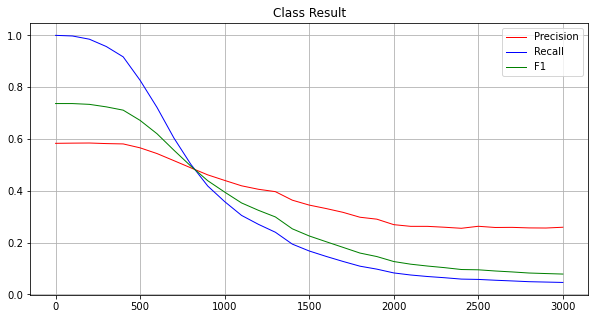

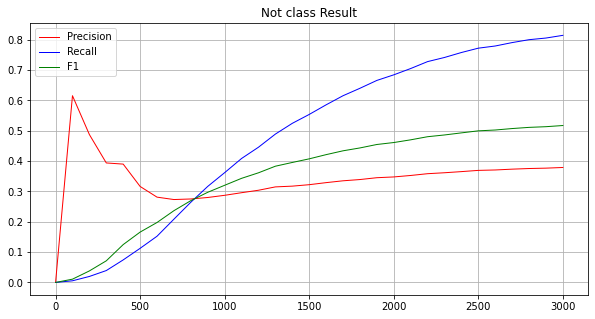

In [22]:
plot_results(train_docs, min_threshold=0, max_threshold=3000, step=100, trace=1)

In [23]:
%%time

TEST_DATA_FILE  = 'kaggle_test_data_tab.csv'

test_docs = load_csv_multiprocess(TEST_DATA_FILE, calc_features)

threshold = 800

with open('my_submission.csv' , 'wt') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Id','Prediction'])
    for item in classifier.predict_all(test_docs):
        prediction = 1 if item[3] > threshold else 0
        writer.writerow([item[0], prediction])

20:36:57 INFO:Complete items 00000 in worker_id 0
20:36:57 INFO:Complete items 00000 in worker_id 1
20:36:57 INFO:Complete items 00000 in worker_id 2
20:36:57 INFO:Complete items 00000
20:36:57 INFO:Complete items 00000 in worker_id 3
20:37:07 INFO:Complete items 01000 in worker_id 2
20:37:07 INFO:Complete items 01000 in worker_id 1
20:37:08 INFO:Complete items 01000
20:37:10 INFO:Complete items 01000 in worker_id 3
20:37:13 INFO:Complete items 01000 in worker_id 0
20:37:15 INFO:Complete items 02000 in worker_id 1
20:37:15 INFO:Complete items 02000 in worker_id 2
20:37:20 INFO:Complete items 02000
20:37:23 INFO:Complete items 02000 in worker_id 0
20:37:23 INFO:Complete items 02000 in worker_id 3
20:37:24 INFO:Complete items 03000 in worker_id 2
20:37:25 INFO:Complete items 03000 in worker_id 1
20:37:28 INFO:Complete items 03000
20:37:30 INFO:Complete items 03000 in worker_id 3
20:37:32 INFO:Complete items 04000 in worker_id 2
20:37:32 INFO:Complete items 03000 in worker_id 0
20:37:33 I

CPU times: user 1.1 s, sys: 279 ms, total: 1.38 s
Wall time: 2min 33s


## Мусорка 

In [ ]:
# def calc_features_multiprocess(docs):
    
#     def process_page_wrapper(i):
#         while not queue.empty():
#             ind = queue.get()
#             features_dict[i].append( (calc_features_worker(docs[]), target[ind]) )

#             with lock:
#                 pbar.update(1)
    
    
#     queue = Queue()

#     for i in range(len(docs)):
#         queue.put(i)

#     processes=4
#     with Pool(processes=processes) as pool, tqdm(total=queue.qsize()) as pbar:
#         features_dict = dict()
#         for i in range(processes):
#             features[i] = []

#         lock = pbar.get_lock()
#         pool.map(process_page_wrapper, range(pool._processes))

#     pool.join()
    
#     features = []
#     labels = []
#     for i in range(processes):
#         for feat, y in features_dict[i]:
#             features.append(feat)
#             labels.append(y)


# vectorizer = get_vectorizer(docc)
# nmf = NMF(n_components=10, max_iter=MAX_ITER, init='random', random_state=0)
# vectors = vectorizer.transform(docc)
# vectors = nmf.fit_transform(vectors) 
# marks = np.array(marks)
# print( vectors.shape )
# print( marks.shape )

# from sklearn.metrics import f1_score
# for cont in [0.4, 0.5]:
#     for nbr in np.arange(30, 51, 5):
#         lof = LOF(contamination=cont, n_neighbors=nbr)
#         y_pred = np.where( lof.fit_predict(vectors) == -1, 1, 0)
#         print('cont: {}, ndr: {} - f1: {}'.format(cont, nbr, f1_score(y_pred, marks)))


# from sklearn.model_selection import StratifiedKFold
# skf = StratifiedKFold(n_splits=3)

# for nu in np.linspace(0.001, 0.5, 20):
#     svm = OneClassSVM(nu=nu)
    
#     scores = []
#     for train_index, test_index in skf.split(vectors, marks):
#         X_train, X_test = vectors[train_index], vectors[test_index]
#         y_train, y_test = marks[train_index], marks[test_index]
        
#         y_pred = svm.fit_predict(X_train)
#         scores.append( f1_score(y_pred, y_test) )
    
#     print('nu: {} - f1: {}'.format(nu, np.mean(scores)))